In [1]:
import pandas as pd

# Load the dataset (if not already in memory)
file_path = "datap/processed_clinical_result.csv"
df = pd.read_csv(file_path)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select features and target
X = df.drop(columns=["position", "label"])
y = df["label"]

# Normalize the numerical feature (Mutation_Frequency)
scaler = StandardScaler()
X["Mutation_Frequency"] = scaler.fit_transform(X[["Mutation_Frequency"]])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape for RNN (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train.values, axis=1)  # (samples, 1, features)
X_test_reshaped = np.expand_dims(X_test.values, axis=1)    # (samples, 1, features)

# Check the new shape
X_train_reshaped.shape, X_test_reshaped.shape


((641, 1, 32), (161, 1, 32))

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the RNN model
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, 32)),  # LSTM with 64 units
    Dropout(0.3),  # Dropout for regularization
    Dense(32, activation="relu"),  # Fully connected layer
    Dense(1, activation="sigmoid")  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()


c:\Users\sravy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,945 (105.25 KB)

 Trainable params: 26,945 (105.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Check data types
print(X_train.dtypes)

# Identify non-numeric columns
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# Convert non-numeric columns to numeric (if needed)
X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(pd.to_numeric, errors='coerce')
X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(pd.to_numeric, errors='coerce')

# Re-check data types
print(X_train.dtypes)


Mutation_Type_Encoded           int64
BP_A>C                           bool
BP_A>G                           bool
BP_A>T                           bool
BP_C>A                           bool
BP_C>G                           bool
BP_C>T                           bool
BP_G>A                           bool
BP_G>C                           bool
BP_G>T                           bool
BP_T>A                           bool
BP_T>C                           bool
BP_T>G                           bool
Normalized_Position           float64
mc_synonymous_variant           int64
mc_3_prime_UTR_variant          int64
mc_5_prime_UTR_variant          int64
mc_splice_donor_variant         int64
mc_splice_acceptor_variant      int64
mc_nonsense                     int64
mc_intron_variant               int64
mc_missense_variant             int64
mc_stop_lost                    int64
Prev_A                           bool
Prev_C                           bool
Prev_G                           bool
Prev_T      

In [6]:
# Convert boolean columns to integers (0 and 1)
X_train = X_train.astype(int)
X_test = X_test.astype(int)

# Reshape for RNN input
X_train_reshaped = np.expand_dims(X_train.values, axis=1)  # (samples, 1, features)
X_test_reshaped = np.expand_dims(X_test.values, axis=1)    # (samples, 1, features)


In [7]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6912 - loss: 0.6694 - val_accuracy: 0.7329 - val_loss: 0.6150
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7595 - loss: 0.5868 - val_accuracy: 0.7329 - val_loss: 0.5448
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7247 - loss: 0.5432 - val_accuracy: 0.7640 - val_loss: 0.4839
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7831 - loss: 0.4746 - val_accuracy: 0.7888 - val_loss: 0.4256
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8054 - loss: 0.4086 - val_accuracy: 0.8385 - val_loss: 0.3727
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8359 - loss: 0.3527 - val_accuracy: 0.8447 - val_loss: 0.3309
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8504 - loss: 0.3282 - val_accuracy: 0.8696 - val_loss: 0.3049
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8776 - loss: 0.2796 - val_accuracy: 0.8758 - val_loss

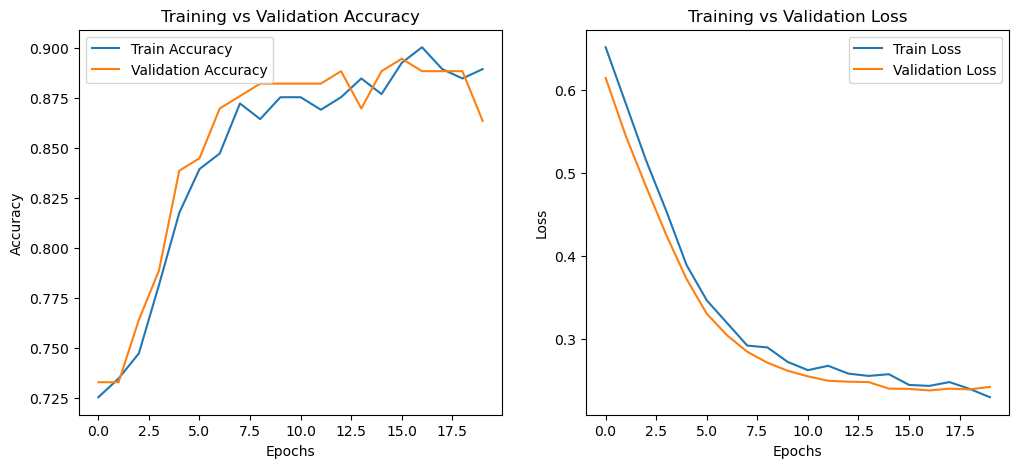

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


In [9]:
# Make predictions
y_pred_probs = model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

# Print some sample predictions
print("Predicted labels:", y_pred[:10].flatten())
print("Actual labels:   ", y_test[:10].values)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted labels: [0 0 1 0 0 0 0 0 0 0]
Actual labels:    [0 0 1 0 0 0 0 0 0 0]


In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.96      0.91       118
           1       0.84      0.60      0.70        43

    accuracy                           0.86       161
   macro avg       0.85      0.78      0.81       161
weighted avg       0.86      0.86      0.86       161

